In [51]:
import limbo
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import tqdm

%matplotlib notebook

In [107]:
#np.savez('bandpass_v002.npz', freqs=hdr['freqs'], mdl=fmdl)
bandpass = np.load('bandpass_v002.npz')

if False:
    import hera_filters
    CH0, CH1 = 400, 400+1024
    freq_filter = {'filter_centers': [0, 830e-9, -830e-9],
                     'filter_half_widths': [400e-9, 100e-9, 100e-9],
                     'eigenval_cutoff': [1e-9] * 3} 
    freq_amat, _ = hera_filters.dspec.dpss_operator(hdr['freqs'], **freq_filter)
    NSIG = 10
    fmdl = bandpass['mdl']
    spec = np.mean(data, axis=0)
    amp = np.median(spec[CH0:CH1] / fmdl[CH0:CH1])
    diff = spec - amp * fmdl
    nos = amp * fmdl / (hdr['AccLen'] * data.shape[0])**0.5
    fmask = diff / nos < NSIG
    np.savez('freq_mask_v001.npz',
             freqs=hdr['freqs'],
             mask=fmask,
             amat=freq_amat,
             fmat=hera_filters.dspec.fit_solution_matrix(np.diag(fmask.astype('float')), freq_amat),
             **freq_filter,
    )
    
freq_mask = np.load('freq_mask_v001.npz')
fmask = freq_mask['mask']
freq_amat = freq_mask['amat']
freq_fmat = freq_mask['fmat']

if False:
    import hera_filters
    time_filter = {'filter_centers': [0, 42, -42],
                     'filter_half_widths': [2, 15, 15],
                     'eigenval_cutoff': [1e-9] * 3} 
    time_amat, _ = hera_filters.dspec.dpss_operator(hdr['times'], **time_filter)
    time_fmat = hera_filters.dspec.fit_solution_matrix(np.diag(np.ones_like(hdr['times'])), time_amat)
    np.savez('time_filt_v001.npz', amat=time_amat, fmat=time_fmat, **time_filter)
    
time_filt = np.load('time_filt_v001.npz')
time_amat = time_filt['amat']
time_fmat = time_filt['fmat']

def dpss_filter(y, amat, fmat):
    '''Apply the provided DPSS filter matrices to data.'''
    model = amat @ (fmat @ y)
    return model.real

def process_data(hdr, data, ch0=400, ch1=400+1024, fmask=fmask, freq_amat=freq_amat,
                 freq_fmat=freq_fmat, time_amat=time_amat, time_fmat=time_fmat):
    spec = np.mean(data, axis=0)
    fmdl = dpss_filter(spec * fmask.astype('float'), freq_amat, freq_fmat)
    tgain = np.sum(data[:,fmask], axis=1, keepdims=False) / np.sum(fmdl[fmask])
    tnos = np.sqrt(np.median(np.abs(tgain - 1)**2))  # XXX not really std
    tmask = (tgain - 1) / tnos < 4 # XXX not really std
    tgain[~tmask] = 1
    #tmdl = dpss_filter(tgain, time_amat, time_fmat)
    tmdl = tgain
    mdl = np.outer(tmdl, fmdl)
    nos = mdl / hdr['AccLen']**0.5
    diff_dat = data - mdl
    #full_mask = np.where(diff_dat > 4 * nos, False, True)
    full_mask = np.ones_like(diff_dat).astype(bool)
    full_mask[:, ~fmask] = False
    full_mask[~tmask] = False
    diff_dat *= full_mask
    fdmt = limbo.fdmt.FDMT(hdr['freqs'][ch0:ch1], hdr['times'], maxDM=4000)
    dm_vs_t = fdmt.apply(diff_dat[:,ch0:ch1])
    rv = {'dmt': dm_vs_t, 'dms': fdmt.dms, 'fmdl': fmdl, 'tmdl': tmdl, 'diff': diff_dat}
    return rv

In [114]:
class Summary:
    
    def __init__(self):
        self.clear()
    
    def clear(self):
        self.dms = {
            (100,200): [],
            (200,300): [],
            (300,400): [],
            (400,500): [],
            (500,1000): [],
            (1000,2000): [],
            (2000,3000): [],
            (3000,4000): [],
        }
        self.avg_spec = []
        self.gain_vs_t = []
    
    def add_summary(self, summary):
        dm_vs_t = summary['dmt']
        dms = summary['dms']
        for (lo, hi) in self.dms.keys():
            self.dms[lo, hi].append(np.max(dm_vs_t[:,np.logical_and(hi > dms, dms >= lo)], axis=1))
        self.avg_spec.append(summary['fmdl'])
        self.gain_vs_t.append(summary['tmdl'])
    
    def get_summary(self):
        rv = {}
        for k, v in self.dms.items():
            rv[k] = np.concatenate(v)
        rv['avg_spec'] = np.array(self.avg_spec)
        rv['gain_vs_t'] = np.array(self.gain_vs_t)
        return rv

In [118]:
INJECT_FRB = False
sim_frb = None

files = sorted(glob.glob('data/*.dat'))
print(files)
filename = files[-1]
#filename = files[-2]
#filename = files[-5]
hdr = limbo.io.read_header(filename)
print(hdr)
report = Summary()

if hdr['nspec'] < 1e5:
    hdr, data = limbo.io.read_file(filename, nspec=-1)
    if INJECT_FRB:
        sim_frb = limbo.sim.make_frb(hdr['times'], hdr['freqs'], DM=331, pulse_width=0.12e-3, pulse_amp=250, t0=hdr['times'][500])
        sim_frb *= (bandpass['mdl'] / bandpass['mdl'].max())
        data = data + sim_frb
    summary = process_data(hdr, data)
    report.add_summary(summary)
    report = report.get_summary()
        
else:
    BLOCK_SIZE = 4096
    nblocks = int(np.ceil(hdr['nspec'] / BLOCK_SIZE))
    report = Summary()
    for block in tqdm.tqdm(range(nblocks)):
        hdr, data = limbo.io.read_file(filename, nspec=BLOCK_SIZE, skip=block*BLOCK_SIZE)
        if INJECT_FRB:
            if sim_frb is None:
                sim_frb = limbo.sim.make_frb(hdr['times'], hdr['freqs'], DM=331, pulse_width=0.12e-3, pulse_amp=250, t0=hdr['times'][500])
                sim_frb *= (bandpass['mdl'] / bandpass['mdl'].max())
            data = data + sim_frb[:data.shape[0]]
        summary = process_data(hdr, data)
        report.add_summary(summary)
    report = report.get_summary()

['data/Spectra_20230109212349.dat', 'data/Spectra_20230127201959.dat', 'data/Spectra_20230127203135.dat', 'data/Spectra_20230127204655.dat', 'data/Spectra_20230127204811.dat', 'data/Spectra_20230127205243.dat', 'data/Spectra_20230127205418.dat', 'data/Spectra_20230127205609.dat', 'data/Spectra_20230127205727.dat', 'data/Spectra_20230127210402.dat', 'data/Spectra_20230127212313.dat', 'data/Spectra_20230127212618.dat', 'data/Spectra_20230127213153.dat', 'data/Spectra_20230127215517.dat', 'data/Spectra_20230127215739.dat', 'data/Spectra_20230127221045.dat', 'data/Spectra_20230127223431.dat', 'data/Spectra_20230127223657.dat', 'data/Spectra_20230127224711.dat', 'data/Spectra_20230127230304.dat', 'data/Spectra_20230127231305.dat', 'data/Spectra_20230127232023.dat', 'data/Spectra_20230127232349.dat', 'data/Spectra_20230127232907.dat', 'data/Spectra_20230127233951.dat']
{'fpg': 'limbo_500_2022-12-03_1749.fpg', 'Time': 1674855102.729957, 'AccLen': 127, 'AdcCoarseGain': 4, 'FFTShift': 2047, 'Sc

100%|█████████████████████████████████████████| 426/426 [03:51<00:00,  1.84it/s]


In [119]:
2 * 1.4e-16 * 100 / (30**2) * (3/180)**2 / 1e-23

864.1975308641977

In [116]:
#for block in tqdm.tqdm(range(426)):
##for block in [150+57]:
##for block in tqdm.tqdm(range(150, 250)):
#    hdr, data = limbo.io.read_file(filename, nspec=4096, skip=block*4096)
#    #data = data + sim_frb
#    spec = np.mean(data, axis=0)
#    fmdl = dpss_filter(spec * fmask.astype('float'), freq_amat, freq_fmat)
#    tgain = np.sum(data[:,fmask], axis=1, keepdims=False) / np.sum(fmdl[fmask])
#    tnos = np.sqrt(np.median(np.abs(tgain - 1)**2))  # XXX not really std
#    tmask = (tgain - 1) / tnos < 4 # XXX not really std
#    tgain[~tmask] = 1
#    tmdl = dpss_filter(tgain, time_amat, time_fmat)
#    mdl = np.outer(tmdl, fmdl)
#    nos = mdl / hdr['AccLen']**0.5
#    diff_dat = data - mdl
#    full_mask = np.where(diff_dat > 4 * nos, False, True)
#    full_mask[:, ~fmask] = 0
#    full_mask[~tmask] = 0
#    diff_dat *= full_mask
#    CH0, CH1 = 400, 400+1024
#    fdmt = limbo.fdmt.FDMT(hdr['freqs'][CH0:CH1], hdr['times'])
#    dm_vs_t = fdmt.apply(diff_dat[:, CH0:CH1])
#    for (lo, hi) in dms.keys():
#        dms[lo, hi].append(np.max(dm_vs_t[:,np.logical_and(hi > fdmt.dms, fdmt.dms >= lo)], axis=1))
#    avg_spec.append(fmdl)
#    gain_vs_t.append(tgain)

<IPython.core.display.Javascript object>


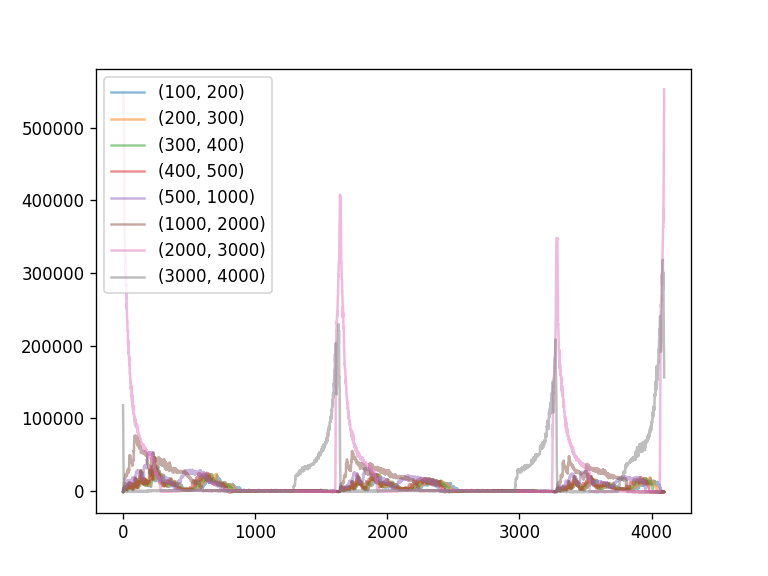

In [117]:
plt.figure()
for k, v in report.items():
    if type(k) == str:
        continue
    plt.plot(v, label=k, alpha=0.5)
plt.legend()

<IPython.core.display.Javascript object>


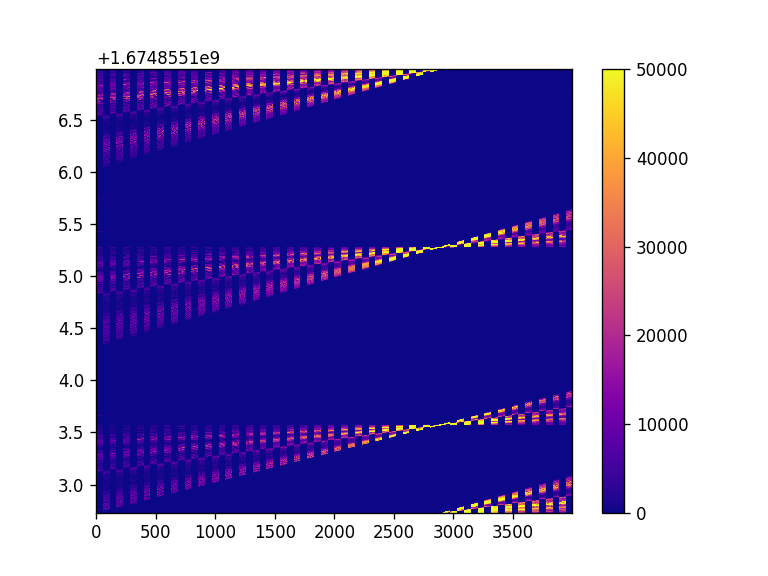

In [113]:
plt.figure()
scale = 50
#plt.imshow(summary['diff'], cmap='plasma', vmax=scale, vmin=-scale, interpolation='nearest', aspect='auto')
plt.imshow(summary['dmt'], cmap='plasma', vmax=50000, vmin=0, 
           extent=(summary['dms'][0], summary['dms'][-1], hdr['times'][0], hdr['times'][-1]),
           interpolation='nearest', aspect='auto')
#plt.imshow(data, cmap='plasma', vmax=5000, vmin=0, interpolation='nearest', aspect='auto')
plt.colorbar()

<IPython.core.display.Javascript object>


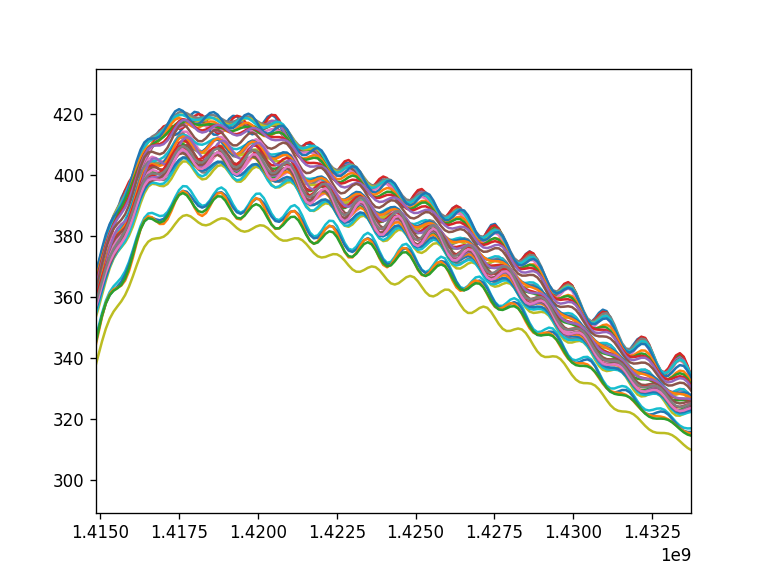

In [125]:
plt.figure()
avg_spec = report['avg_spec']
#plt.plot(hdr['freqs'], (avg_spec[::10] / avg_spec[-1:]).T )
plt.plot(hdr['freqs'], avg_spec[::10].T)
#plt.ylim(0.95, 1.13)

In [ ]:
plt.figure()
plt.plot(np.concatenate(gain_vs_t))

In [ ]:
#freqs = hdr['freqs']
freqs = np.arange(hdr['freqs'].size)

plt.figure()
plt.plot(freqs, spec)
plt.plot(freqs, fmdl)
plt.plot(freqs[fmask], (spec - fmdl)[fmask])
plt.ylim(0, 1000)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.grid()

In [ ]:
#times = hdr['times']
times = np.arange(hdr['times'].size)
plt.figure()
plt.plot(times, tgain - 1)
plt.plot(times, tmdl - 1)
plt.plot(times, tgain - tmdl)
plt.xlabel('Time')
plt.ylabel('Power')

In [ ]:
def watershed(fin, zscore, nsig=2):
    from scipy.signal import convolve
    fout = fin.copy()
    kernel = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    while True:
        nflags = np.sum(fout)
        is_neighbor_flagged = convolve(fout, kernel, mode='same').astype(bool)
        fout |= (is_neighbor_flagged & (zscore >= nsig))
        if np.sum(fout) == nflags:
            break
    return fout

In [ ]:
#new_mask = ~watershed(~full_mask, diff_dat / nos)

In [ ]:
DIFF_SCALE = 50
fig, ax = plt.subplots(figsize=(8,8), ncols=2, sharex=True, sharey=True)
ax[0].imshow(data, cmap='plasma', aspect='auto', interpolation='nearest', vmax=500)
#ax[1].imshow((data - mdl) / nos, cmap='RdBu', vmax=DIFF_SCALE, vmin=-DIFF_SCALE, aspect='auto', interpolation='nearest')
#ax[1].imshow(diff_dat, cmap='RdBu', vmax=DIFF_SCALE, vmin=-DIFF_SCALE, aspect='auto', interpolation='nearest')
ax[1].imshow(diff_dat / nos, cmap='RdBu', vmax=5, vmin=-5, aspect='auto', interpolation='nearest')
#ax[1].imshow(full_mask, cmap='gray', aspect='auto', interpolation='nearest')
#ax[1].imshow(new_mask, cmap='gray', alpha=0.5, aspect='auto', interpolation='nearest')

In [ ]:
plt.figure()
plt.imshow(dm_vs_t, cmap='plasma',
           extent=(fdmt.dms[0], fdmt.dms[-1], hdr['times'][-1] - hdr['times'][0], 0),
           aspect='auto', interpolation='nearest')
plt.colorbar()

In [ ]:
plt.figure()
times = np.arange(hdr['times'].size)
#plt.plot(hdr['times'], np.max(dm_vs_t[:,np.logical_and( 25 > fdmt.dms, fdmt.dms >=  12)], axis=1))
#plt.plot(hdr['times'], np.max(dm_vs_t[:,np.logical_and( 50 > fdmt.dms, fdmt.dms >=  25)], axis=1))
#plt.plot(hdr['times'], np.max(dm_vs_t[:,np.logical_and(100 > fdmt.dms, fdmt.dms >=  50)], axis=1))
plt.plot(times, np.max(dm_vs_t[:,np.logical_and(200 > fdmt.dms, fdmt.dms >= 100)], axis=1))
plt.plot(times, np.max(dm_vs_t[:,np.logical_and(300 > fdmt.dms, fdmt.dms >= 200)], axis=1))
plt.plot(times, np.max(dm_vs_t[:,np.logical_and(400 > fdmt.dms, fdmt.dms >= 300)], axis=1))
plt.plot(times, np.max(dm_vs_t[:,np.logical_and(500 > fdmt.dms, fdmt.dms >= 400)], axis=1))
plt.vlines(times[553], color='k', linestyle='dotted', linewidth=2, ymin=-5e3, ymax=1e4)
#plt.plot(hdr['times'], np.max(dm_vs_t[:,fdmt.dms > 200], axis=1))
#plt.plot(hdr['times'], np.max(dm_vs_t[:,fdmt.dms > 200], axis=1))